In [2]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from ultralytics import YOLO
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import cv2, torch, os
import numpy as np
from glob import glob

## Linear Fusion

In [2]:
class FusedSaliencyDataset(Dataset):
    def __init__(self, raw_dir, sal_dir, label_dir, alpha=0.3, img_size=640):
        self.alpha = alpha
        self.img_size = img_size
        self.samples = sorted(glob(os.path.join(raw_dir, '*')))
        self.sal_dir = sal_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        raw_path = self.samples[idx]
        filename = os.path.basename(raw_path)
        sal_path = os.path.join(self.sal_dir, filename)
        label_path = os.path.join(self.label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))

        # Fuse
        raw = cv2.imread(raw_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
        sal = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
        fused = np.clip(self.alpha * sal + (1 - self.alpha) * raw, 0, 1)

        fused_resized = cv2.resize(fused, (self.img_size, self.img_size))
        fused_rgb = np.stack([fused_resized]*3, axis=-1) * 255
        fused_rgb = fused_rgb.astype(np.uint8)

        # Ground truth
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls, x, y, w, h = map(float, line.strip().split())
                    labels.append([cls, x, y, w, h])

        return fused_rgb, labels, filename

In [3]:
metric_a = MeanAveragePrecision(iou_type="bbox")
metric_b = MeanAveragePrecision(iou_type="bbox")

In [4]:
def run_evaluation(model, dataset, metric):
    metric.reset()
    for fused_img, targets, _ in tqdm(dataset, desc="Eval"):
        # Predict (fused_img: np.uint8 H×W×3)
        results = model.predict(fused_img, imgsz=640, conf=0.01, iou=0.5, verbose=False)[0]
        
        # Build prediction dict
        preds = {
            "boxes": torch.tensor(results.boxes.xyxy.cpu().numpy(), dtype=torch.float32),
            "scores": torch.tensor(results.boxes.conf.cpu().numpy(), dtype=torch.float32),
            "labels": torch.tensor(results.boxes.cls.cpu().numpy().astype(int), dtype=torch.int64)
        }
        
        # Build target dict
        gt_boxes = []
        gt_labels = []
        for cls, x, y, w, h in targets:
            # convert normalized xywh to absolute xyxy on 640×640
            x1 = (x - w/2) * 640; y1 = (y - h/2) * 640
            x2 = (x + w/2) * 640; y2 = (y + h/2) * 640
            gt_boxes.append([x1, y1, x2, y2])
            gt_labels.append(int(cls))
        target = {
            "boxes": torch.tensor(gt_boxes, dtype=torch.float32),
            "labels": torch.tensor(gt_labels, dtype=torch.int64)
        }
        
        # Update metric
        metric.update([preds], [target])
    
    return metric.compute()

In [5]:
# Directories
raw_dir = '/home/samy/shivam/dsr_project/dataset/IR-data/Object_Detection_Compliled/images/test'
sal_dir = '/home/samy/shivam/dsr_project/salguided_od_datasets/IR_predicted_masks/combined/images/test'
label_dir = '/home/samy/shivam/dsr_project/dataset/IR-data/Object_Detection_Compliled/labels/test'

model_a = YOLO('/home/samy/shivam/dsr_project/Project_files/runs/yolov11_ir_d6/train_n/weights/best.pt')
model_b = YOLO('/home/samy/shivam/dsr_project/Project_files/runs/yolov11_ir_salfused_d6/train_pre_d6/weights/best.pt')
alphas = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0]
results_a, results_b = [], []
for alpha in alphas:
    ds = FusedSaliencyDataset(raw_dir, sal_dir, label_dir, alpha=alpha)
    
    print(f"\n▶️ Alpha = {alpha}")
    res_a = run_evaluation(model_a, ds, metric_a)
    res_b = run_evaluation(model_b, ds, metric_b)
    
    # res_a is a dict with keys like 'map_50', 'map', 'recall', 'precision', etc.
    print(f" Model A (raw):  mAP@[.5:.95] = {res_a['map']:.4f},  mAP@0.5 = {res_a['map_50']:.4f},  Recall@100 = {res_a['mar_100']:.4f}")
    print(f" Model B (fused): mAP@[.5:.95] = {res_b['map']:.4f},  mAP@0.5 = {res_b['map_50']:.4f},  Recall@100 = {res_b['mar_100']:.4f}")


    results_a.append((alpha, res_a['map_50'].item(), res_a['map'].item()))
    results_b.append((alpha, res_b['map_50'].item(), res_b['map'].item()))


▶️ Alpha = 0


Eval:   0%|          | 0/3157 [00:00<?, ?it/s]

Eval:   9%|▉         | 290/3157 [00:03<00:29, 96.36it/s] /home/samy/anaconda3/envs/shivam/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)
Eval: 100%|██████████| 3157/3157 [00:26<00:00, 118.34it/s]


 Model A (raw):  mAP@[.5:.95] = 0.5461,  mAP@0.5 = 0.8801,  Recall@100 = 0.6102
 Model B (fused): mAP@[.5:.95] = 0.4956,  mAP@0.5 = 0.8466,  Recall@100 = 0.5637

▶️ Alpha = 0.1


Eval: 100%|██████████| 3157/3157 [00:27<00:00, 116.48it/s]


 Model A (raw):  mAP@[.5:.95] = 0.5355,  mAP@0.5 = 0.8729,  Recall@100 = 0.6027
 Model B (fused): mAP@[.5:.95] = 0.5283,  mAP@0.5 = 0.8677,  Recall@100 = 0.5946

▶️ Alpha = 0.15


Eval: 100%|██████████| 3157/3157 [00:29<00:00, 107.42it/s]


 Model A (raw):  mAP@[.5:.95] = 0.5242,  mAP@0.5 = 0.8643,  Recall@100 = 0.5951
 Model B (fused): mAP@[.5:.95] = 0.5414,  mAP@0.5 = 0.8737,  Recall@100 = 0.6049

▶️ Alpha = 0.2


Eval: 100%|██████████| 3157/3157 [00:29<00:00, 108.09it/s]


 Model A (raw):  mAP@[.5:.95] = 0.5038,  mAP@0.5 = 0.8510,  Recall@100 = 0.5793
 Model B (fused): mAP@[.5:.95] = 0.5481,  mAP@0.5 = 0.8785,  Recall@100 = 0.6113

▶️ Alpha = 0.25


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 110.74it/s]


 Model A (raw):  mAP@[.5:.95] = 0.4775,  mAP@0.5 = 0.8252,  Recall@100 = 0.5607
 Model B (fused): mAP@[.5:.95] = 0.5568,  mAP@0.5 = 0.8772,  Recall@100 = 0.6197

▶️ Alpha = 0.3


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 109.45it/s]


 Model A (raw):  mAP@[.5:.95] = 0.4449,  mAP@0.5 = 0.7894,  Recall@100 = 0.5383
 Model B (fused): mAP@[.5:.95] = 0.5632,  mAP@0.5 = 0.8800,  Recall@100 = 0.6241

▶️ Alpha = 0.35


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 109.20it/s]


 Model A (raw):  mAP@[.5:.95] = 0.4068,  mAP@0.5 = 0.7567,  Recall@100 = 0.5089
 Model B (fused): mAP@[.5:.95] = 0.5647,  mAP@0.5 = 0.8780,  Recall@100 = 0.6254

▶️ Alpha = 0.4


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 111.67it/s]


 Model A (raw):  mAP@[.5:.95] = 0.3676,  mAP@0.5 = 0.7207,  Recall@100 = 0.4763
 Model B (fused): mAP@[.5:.95] = 0.5634,  mAP@0.5 = 0.8752,  Recall@100 = 0.6273

▶️ Alpha = 0.45


Eval: 100%|██████████| 3157/3157 [00:29<00:00, 108.13it/s]


 Model A (raw):  mAP@[.5:.95] = 0.3274,  mAP@0.5 = 0.6718,  Recall@100 = 0.4408
 Model B (fused): mAP@[.5:.95] = 0.5495,  mAP@0.5 = 0.8608,  Recall@100 = 0.6159

▶️ Alpha = 0.5


Eval: 100%|██████████| 3157/3157 [00:29<00:00, 106.40it/s]


 Model A (raw):  mAP@[.5:.95] = 0.2829,  mAP@0.5 = 0.5950,  Recall@100 = 0.4008
 Model B (fused): mAP@[.5:.95] = 0.5206,  mAP@0.5 = 0.8387,  Recall@100 = 0.5959

▶️ Alpha = 0.55


Eval: 100%|██████████| 3157/3157 [00:27<00:00, 113.12it/s]


 Model A (raw):  mAP@[.5:.95] = 0.2339,  mAP@0.5 = 0.5047,  Recall@100 = 0.3511
 Model B (fused): mAP@[.5:.95] = 0.4745,  mAP@0.5 = 0.7920,  Recall@100 = 0.5612

▶️ Alpha = 0.6


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 109.13it/s]


 Model A (raw):  mAP@[.5:.95] = 0.1728,  mAP@0.5 = 0.3844,  Recall@100 = 0.2787
 Model B (fused): mAP@[.5:.95] = 0.4227,  mAP@0.5 = 0.7307,  Recall@100 = 0.5215

▶️ Alpha = 0.65


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 111.69it/s]


 Model A (raw):  mAP@[.5:.95] = 0.1302,  mAP@0.5 = 0.2999,  Recall@100 = 0.2184
 Model B (fused): mAP@[.5:.95] = 0.3599,  mAP@0.5 = 0.6486,  Recall@100 = 0.4658

▶️ Alpha = 0.7


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 110.11it/s]


 Model A (raw):  mAP@[.5:.95] = 0.1056,  mAP@0.5 = 0.2486,  Recall@100 = 0.1794
 Model B (fused): mAP@[.5:.95] = 0.2975,  mAP@0.5 = 0.5529,  Recall@100 = 0.3943

▶️ Alpha = 0.75


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 109.60it/s]


 Model A (raw):  mAP@[.5:.95] = 0.0905,  mAP@0.5 = 0.2159,  Recall@100 = 0.1599
 Model B (fused): mAP@[.5:.95] = 0.2434,  mAP@0.5 = 0.4596,  Recall@100 = 0.3307

▶️ Alpha = 0.8


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 109.52it/s]


 Model A (raw):  mAP@[.5:.95] = 0.0724,  mAP@0.5 = 0.1772,  Recall@100 = 0.1415
 Model B (fused): mAP@[.5:.95] = 0.2023,  mAP@0.5 = 0.3850,  Recall@100 = 0.2845

▶️ Alpha = 0.85


Eval: 100%|██████████| 3157/3157 [00:28<00:00, 110.94it/s]


 Model A (raw):  mAP@[.5:.95] = 0.0456,  mAP@0.5 = 0.1134,  Recall@100 = 0.1050
 Model B (fused): mAP@[.5:.95] = 0.1432,  mAP@0.5 = 0.2868,  Recall@100 = 0.2124

▶️ Alpha = 0.9


Eval: 100%|██████████| 3157/3157 [00:27<00:00, 112.96it/s]


 Model A (raw):  mAP@[.5:.95] = 0.0224,  mAP@0.5 = 0.0694,  Recall@100 = 0.0631
 Model B (fused): mAP@[.5:.95] = 0.1053,  mAP@0.5 = 0.2148,  Recall@100 = 0.1633

▶️ Alpha = 0.95


Eval: 100%|██████████| 3157/3157 [00:27<00:00, 113.81it/s]


 Model A (raw):  mAP@[.5:.95] = 0.0186,  mAP@0.5 = 0.0599,  Recall@100 = 0.0495
 Model B (fused): mAP@[.5:.95] = 0.0603,  mAP@0.5 = 0.1314,  Recall@100 = 0.1222

▶️ Alpha = 1.0


Eval: 100%|██████████| 3157/3157 [00:27<00:00, 113.06it/s]


 Model A (raw):  mAP@[.5:.95] = 0.0165,  mAP@0.5 = 0.0553,  Recall@100 = 0.0409
 Model B (fused): mAP@[.5:.95] = 0.0414,  mAP@0.5 = 0.0958,  Recall@100 = 0.0823


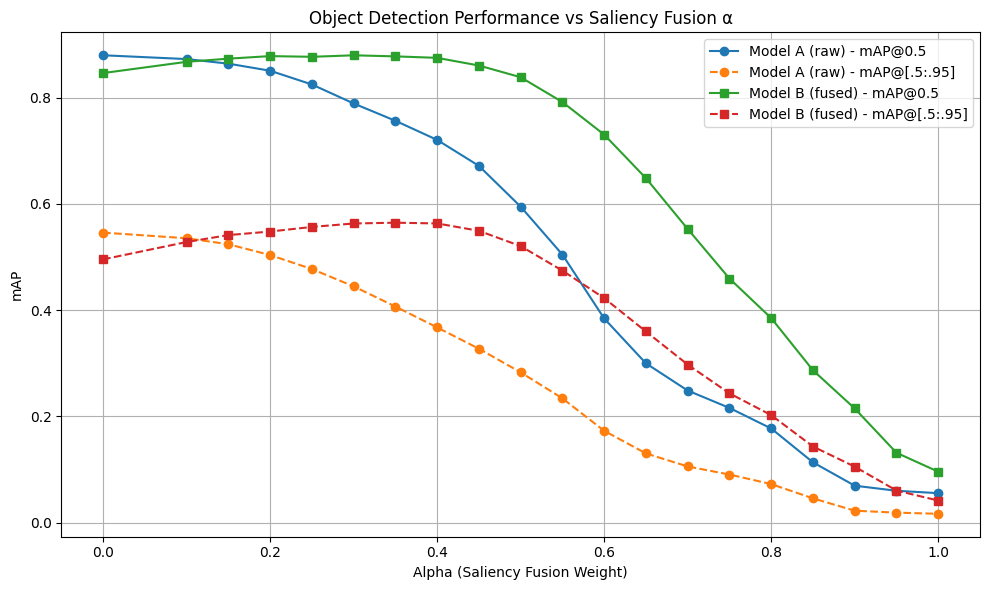

In [6]:
import matplotlib.pyplot as plt

# Unpack values
alphas_plot = [a for a, _, _ in results_a]
map50_a     = [m50 for _, m50, _ in results_a]
map5095_a   = [m5095 for _, _, m5095 in results_a]

map50_b     = [m50 for _, m50, _ in results_b]
map5095_b   = [m5095 for _, _, m5095 in results_b]

# Plotting
plt.figure(figsize=(10,6))

plt.plot(alphas_plot, map50_a, marker='o', linestyle='-', label='Model A (raw) - mAP@0.5')
plt.plot(alphas_plot, map5095_a, marker='o', linestyle='--', label='Model A (raw) - mAP@[.5:.95]')

plt.plot(alphas_plot, map50_b, marker='s', linestyle='-', label='Model B (fused) - mAP@0.5')
plt.plot(alphas_plot, map5095_b, marker='s', linestyle='--', label='Model B (fused) - mAP@[.5:.95]')

plt.xlabel('Alpha (Saliency Fusion Weight)')
plt.ylabel('mAP')
plt.title('Object Detection Performance vs Saliency Fusion α')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Multiplicative Fusion

In [1]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from ultralytics import YOLO
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import cv2, torch, os
import numpy as np
from glob import glob

## Multiplicative Fusion
class FusedSaliencyDataset(Dataset):
    def __init__(self, raw_dir, sal_dir, label_dir, alpha=0.3, img_size=640):
        self.alpha = alpha
        self.img_size = img_size
        self.samples = sorted(glob(os.path.join(raw_dir, '*')))
        self.sal_dir = sal_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        raw_path = self.samples[idx]
        filename = os.path.basename(raw_path)
        sal_path = os.path.join(self.sal_dir, filename)
        label_path = os.path.join(self.label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))

        # Load and normalize
        raw = cv2.imread(raw_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
        sal = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255

        # ✅ Multiplicative Fusion
        fused = np.clip(np.power(raw, 1 - self.alpha) * np.power(sal, self.alpha), 0, 1)

        fused_resized = cv2.resize(fused, (self.img_size, self.img_size))
        fused_rgb = np.stack([fused_resized]*3, axis=-1) * 255
        fused_rgb = fused_rgb.astype(np.uint8)

        # Ground truth
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls, x, y, w, h = map(float, line.strip().split())
                    labels.append([cls, x, y, w, h])

        return fused_rgb, labels, filename


In [2]:
metric_a = MeanAveragePrecision(iou_type="bbox")
metric_b = MeanAveragePrecision(iou_type="bbox")

def run_evaluation(model, dataset, metric):
    metric.reset()
    for fused_img, targets, _ in tqdm(dataset, desc="Eval"):
        results = model.predict(fused_img, imgsz=640, conf=0.01, iou=0.5, verbose=False)[0]

        preds = {
            "boxes": torch.tensor(results.boxes.xyxy.cpu().numpy(), dtype=torch.float32),
            "scores": torch.tensor(results.boxes.conf.cpu().numpy(), dtype=torch.float32),
            "labels": torch.tensor(results.boxes.cls.cpu().numpy().astype(int), dtype=torch.int64)
        }

        gt_boxes = []
        gt_labels = []
        for cls, x, y, w, h in targets:
            x1 = (x - w/2) * 640; y1 = (y - h/2) * 640
            x2 = (x + w/2) * 640; y2 = (y + h/2) * 640
            gt_boxes.append([x1, y1, x2, y2])
            gt_labels.append(int(cls))
        target = {
            "boxes": torch.tensor(gt_boxes, dtype=torch.float32),
            "labels": torch.tensor(gt_labels, dtype=torch.int64)
        }

        metric.update([preds], [target])

    return metric.compute()


In [3]:
# Directories
raw_dir = '/home/samy/shivam/dsr_project/dataset/IR-data/Object_Detection_Compliled/images/test'
sal_dir = '/home/samy/shivam/dsr_project/salguided_od_datasets/IR_predicted_masks/combined/images/test'
label_dir = '/home/samy/shivam/dsr_project/dataset/IR-data/Object_Detection_Compliled/labels/test'

model_a = YOLO('/home/samy/shivam/dsr_project/Project_files/runs/yolov11_ir_d6/train_n/weights/best.pt')
model_b = YOLO('/home/samy/shivam/dsr_project/Project_files/runs/yolov11_ir_salfused_d6/train_pre_d6/weights/best.pt')

alphas = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
          0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0]

results_a, results_b = [], []

for alpha in alphas:
    ds = FusedSaliencyDataset(raw_dir, sal_dir, label_dir, alpha=alpha)

    print(f"\n▶️ Alpha = {alpha}")
    res_a = run_evaluation(model_a, ds, metric_a)
    res_b = run_evaluation(model_b, ds, metric_b)

    print(f" Model A (raw):  mAP@[.5:.95] = {res_a['map']:.4f},  mAP@0.5 = {res_a['map_50']:.4f},  Recall@100 = {res_a['mar_100']:.4f}")
    print(f" Model B (fused): mAP@[.5:.95] = {res_b['map']:.4f},  mAP@0.5 = {res_b['map_50']:.4f},  Recall@100 = {res_b['mar_100']:.4f}")

    results_a.append((alpha, res_a['map_50'].item(), res_a['map'].item()))
    results_b.append((alpha, res_b['map_50'].item(), res_b['map'].item()))



▶️ Alpha = 0


Eval:   9%|▉         | 289/3157 [00:03<00:40, 70.86it/s]/home/samy/anaconda3/envs/shivam/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)
Eval: 100%|██████████| 3157/3157 [00:31<00:00, 99.29it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.5461,  mAP@0.5 = 0.8801,  Recall@100 = 0.6102
 Model B (fused): mAP@[.5:.95] = 0.4956,  mAP@0.5 = 0.8466,  Recall@100 = 0.5637

▶️ Alpha = 0.1


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 93.95it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.1402,  mAP@0.5 = 0.2584,  Recall@100 = 0.2066
 Model B (fused): mAP@[.5:.95] = 0.1904,  mAP@0.5 = 0.3467,  Recall@100 = 0.2547

▶️ Alpha = 0.15


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 94.62it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.1250,  mAP@0.5 = 0.2348,  Recall@100 = 0.1912
 Model B (fused): mAP@[.5:.95] = 0.2031,  mAP@0.5 = 0.3710,  Recall@100 = 0.2600

▶️ Alpha = 0.2


Eval: 100%|██████████| 3157/3157 [00:32<00:00, 95.76it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.1028,  mAP@0.5 = 0.1992,  Recall@100 = 0.1705
 Model B (fused): mAP@[.5:.95] = 0.2090,  mAP@0.5 = 0.3898,  Recall@100 = 0.2595

▶️ Alpha = 0.25


Eval: 100%|██████████| 3157/3157 [00:32<00:00, 96.18it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0871,  mAP@0.5 = 0.1748,  Recall@100 = 0.1475
 Model B (fused): mAP@[.5:.95] = 0.1980,  mAP@0.5 = 0.3876,  Recall@100 = 0.2586

▶️ Alpha = 0.3


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 95.27it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0659,  mAP@0.5 = 0.1447,  Recall@100 = 0.1316
 Model B (fused): mAP@[.5:.95] = 0.1867,  mAP@0.5 = 0.3634,  Recall@100 = 0.2531

▶️ Alpha = 0.35


Eval: 100%|██████████| 3157/3157 [00:32<00:00, 95.77it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0557,  mAP@0.5 = 0.1270,  Recall@100 = 0.1087
 Model B (fused): mAP@[.5:.95] = 0.1640,  mAP@0.5 = 0.3226,  Recall@100 = 0.2282

▶️ Alpha = 0.4


Eval: 100%|██████████| 3157/3157 [00:32<00:00, 95.73it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0489,  mAP@0.5 = 0.1173,  Recall@100 = 0.0983
 Model B (fused): mAP@[.5:.95] = 0.1440,  mAP@0.5 = 0.2882,  Recall@100 = 0.2267

▶️ Alpha = 0.45


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 94.89it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0434,  mAP@0.5 = 0.1098,  Recall@100 = 0.0898
 Model B (fused): mAP@[.5:.95] = 0.1265,  mAP@0.5 = 0.2627,  Recall@100 = 0.2071

▶️ Alpha = 0.5


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 95.62it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0386,  mAP@0.5 = 0.1035,  Recall@100 = 0.0831
 Model B (fused): mAP@[.5:.95] = 0.1149,  mAP@0.5 = 0.2436,  Recall@100 = 0.1935

▶️ Alpha = 0.55


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 94.69it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0336,  mAP@0.5 = 0.0949,  Recall@100 = 0.0760
 Model B (fused): mAP@[.5:.95] = 0.1034,  mAP@0.5 = 0.2244,  Recall@100 = 0.1732

▶️ Alpha = 0.6


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 93.78it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0295,  mAP@0.5 = 0.0851,  Recall@100 = 0.0695
 Model B (fused): mAP@[.5:.95] = 0.0935,  mAP@0.5 = 0.2054,  Recall@100 = 0.1566

▶️ Alpha = 0.65


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 95.25it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0258,  mAP@0.5 = 0.0765,  Recall@100 = 0.0630
 Model B (fused): mAP@[.5:.95] = 0.0870,  mAP@0.5 = 0.1908,  Recall@100 = 0.1466

▶️ Alpha = 0.7


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 94.67it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0229,  mAP@0.5 = 0.0693,  Recall@100 = 0.0577
 Model B (fused): mAP@[.5:.95] = 0.0809,  mAP@0.5 = 0.1773,  Recall@100 = 0.1384

▶️ Alpha = 0.75


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 95.04it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0198,  mAP@0.5 = 0.0629,  Recall@100 = 0.0531
 Model B (fused): mAP@[.5:.95] = 0.0732,  mAP@0.5 = 0.1599,  Recall@100 = 0.1273

▶️ Alpha = 0.8


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 95.30it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0181,  mAP@0.5 = 0.0586,  Recall@100 = 0.0491
 Model B (fused): mAP@[.5:.95] = 0.0661,  mAP@0.5 = 0.1476,  Recall@100 = 0.1174

▶️ Alpha = 0.85


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 95.19it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0170,  mAP@0.5 = 0.0555,  Recall@100 = 0.0462
 Model B (fused): mAP@[.5:.95] = 0.0565,  mAP@0.5 = 0.1290,  Recall@100 = 0.0964

▶️ Alpha = 0.9


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 94.27it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0168,  mAP@0.5 = 0.0550,  Recall@100 = 0.0448
 Model B (fused): mAP@[.5:.95] = 0.0507,  mAP@0.5 = 0.1171,  Recall@100 = 0.0880

▶️ Alpha = 0.95


Eval: 100%|██████████| 3157/3157 [00:33<00:00, 94.85it/s] 


 Model A (raw):  mAP@[.5:.95] = 0.0177,  mAP@0.5 = 0.0559,  Recall@100 = 0.0431
 Model B (fused): mAP@[.5:.95] = 0.0476,  mAP@0.5 = 0.1090,  Recall@100 = 0.0848

▶️ Alpha = 1.0


Eval: 100%|██████████| 3157/3157 [00:30<00:00, 104.09it/s]


 Model A (raw):  mAP@[.5:.95] = 0.0165,  mAP@0.5 = 0.0553,  Recall@100 = 0.0409
 Model B (fused): mAP@[.5:.95] = 0.0414,  mAP@0.5 = 0.0958,  Recall@100 = 0.0823


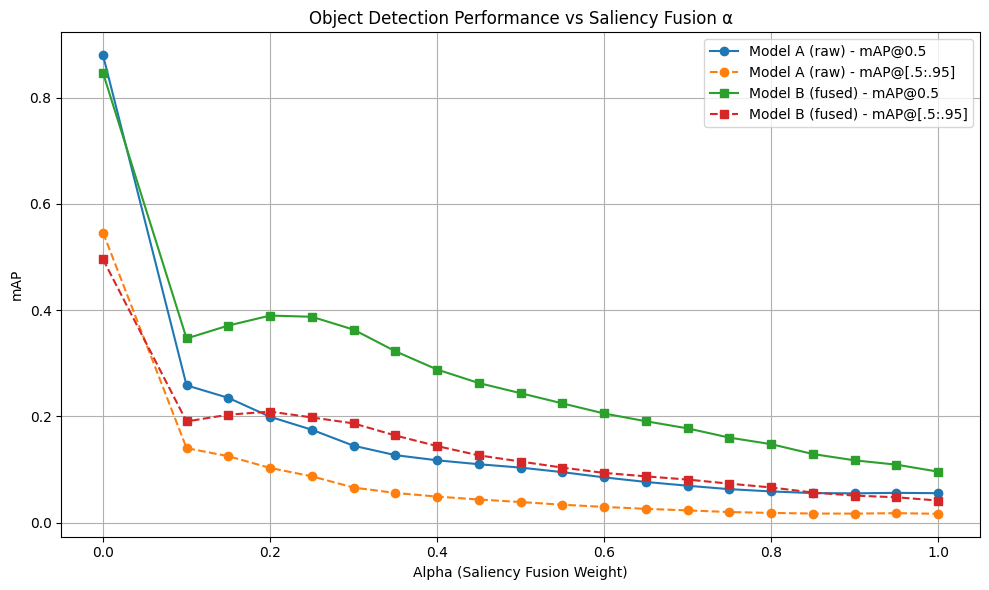

In [4]:
import matplotlib.pyplot as plt

# Unpack values
alphas_plot = [a for a, _, _ in results_a]
map50_a     = [m50 for _, m50, _ in results_a]
map5095_a   = [m5095 for _, _, m5095 in results_a]

map50_b     = [m50 for _, m50, _ in results_b]
map5095_b   = [m5095 for _, _, m5095 in results_b]

# Plotting
plt.figure(figsize=(10,6))

plt.plot(alphas_plot, map50_a, marker='o', linestyle='-', label='Model A (raw) - mAP@0.5')
plt.plot(alphas_plot, map5095_a, marker='o', linestyle='--', label='Model A (raw) - mAP@[.5:.95]')

plt.plot(alphas_plot, map50_b, marker='s', linestyle='-', label='Model B (fused) - mAP@0.5')
plt.plot(alphas_plot, map5095_b, marker='s', linestyle='--', label='Model B (fused) - mAP@[.5:.95]')

plt.xlabel('Alpha (Saliency Fusion Weight)')
plt.ylabel('mAP')
plt.title('Object Detection Performance vs Saliency Fusion α')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()